In [2]:
import os
os.chdir('..')

In this notebook, we will explore regime classification models. In particular, the Gaussian Mixture Model (GMM) and the Gaussian Mixture Autoregressive (MAR) model.

Refer to the following sources:
- For GMM: https://www.youtube.com/watch?v=EWd1xRkyEog
- For MAR: "On a mixture autoregressive model"  https://www.jstor.org/stable/2680680

# Import Files and Download Price

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

from src.yahoo_finance import *

In order to verify that our intepretation of the math is aligned with the paper, we will use the same dataset: IBM common stock closing price from 17 May 1961 to 2 Nov 1962. 

However, given that Yahoo Finance only has data dating back to 1962, we will move slightly forward and use the closing price from 2 Jan 1962 to 1 May 1963.

In [4]:
params = {
    'symbol': 'IBM',
    'start_date': '1962-01-02',
    'end_date': '1963-05-01',
    'interval': '1d'
}
yf = YahooFinance(**params)
df = yf.pipeline()
df.head(5)

[*********************100%***********************]  1 of 1 completed


,date,adj_close,log_return
0,1962-01-02,1.463670,NaN
1,1962-01-03,1.476464,0.008703
2,1962-01-04,1.461751,-0.010015
3,1962-01-05,1.432963,-0.019890
4,1962-01-08,1.406096,-0.018927


In [5]:
df['first_diff'] = df['adj_close'].diff(1)
df = df.dropna().reset_index(drop=True)
df.head(5)

,date,adj_close,log_return,first_diff
0,1962-01-03,1.476464,0.008703,0.012793
1,1962-01-04,1.461751,-0.010015,-0.014713
2,1962-01-05,1.432963,-0.019890,-0.028788
3,1962-01-08,1.406096,-0.018927,-0.026867
4,1962-01-09,1.422729,0.011760,0.016633


# Exploratory Data Analysis

Based on the charts, the difference in dates should not make too big of a difference as the histogram still shows a bimodal distribution. Moreover, we still captured the big drop in stock price and the normal market regime.

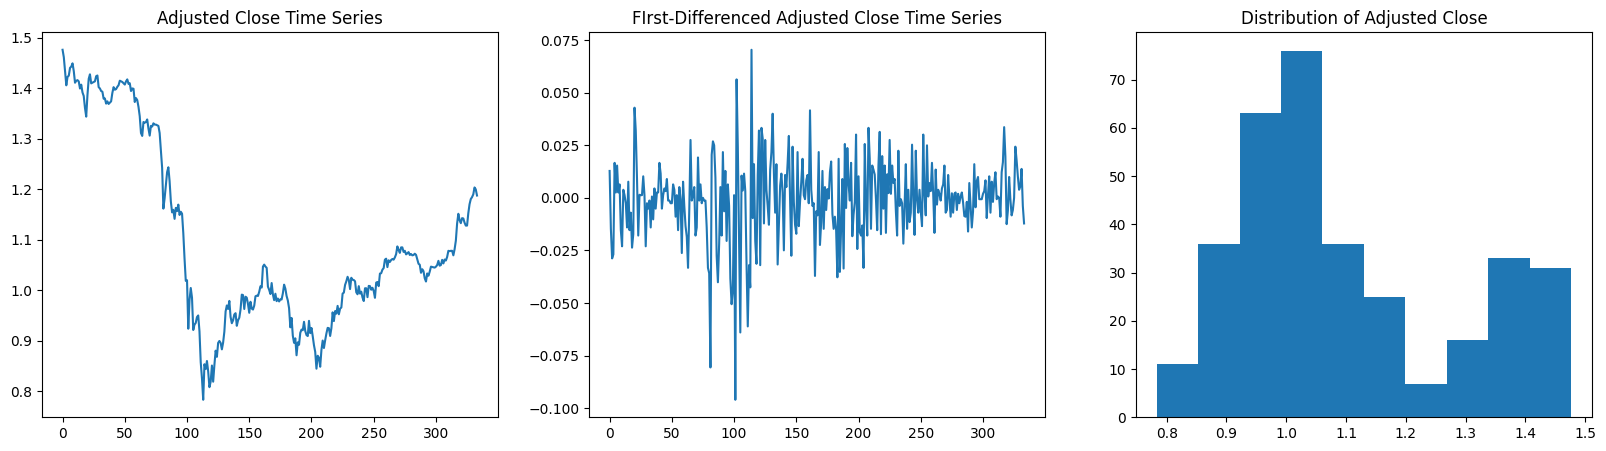

In [6]:
fig, axes= plt.subplots(ncols=3, figsize=(20,5))
axes[0].plot(df['adj_close'])
axes[0].set_title("Adjusted Close Time Series")

axes[1].plot(df['first_diff'])
axes[1].set_title('FIrst-Differenced Adjusted Close Time Series')

axes[2].hist(df['adj_close'])
axes[2].set_title('Distribution of Adjusted Close')
plt.show()

# Gaussian Mixture Model (GMM)
GMM is an unsupervised method to cluster data through a probabilistic model that represents data as a combination of several Gaussian distributions.

Below are the key assumptions:
- Gaussian distributions have their own mean and variance. $X_1 \sim N(x | \mu_1, \Sigma_1)$
- Observations are independent and come from one of the distributions.
- Number of components is known or specified.
- Data points belong to all components with certain probabilities (soft cluster membership). $P(x) = P(x \in X_1) + P(x \in X_2)$

## Expectation Step
We define the posterior probability or cluster responsibility as $P(z_n = k | x_n)$:
$$ \gamma(z_{i,k})= \frac{\pi_kN(x_n | \mu_k, \Sigma_k)}{\sum^K_{k=1} \pi_kN(x_n | \mu_k, \Sigma_k)}$$
where $z_{i, k}$ is the latent variable indicating the cluster group, $\pi_k$ is the mixing probability of the k-th Gaussian.

## Maximization Step
We define the expected complete-data log-likelihood as:
$$Q(\theta, \theta^{old}) = \sum^n_{i=1}\sum^K_{k=1}\gamma(z_{i,k})log\left[\pi_kN(x_i | \mu_k, \Sigma_k)\right]$$

After differentiating it w.r.t each parameter, we get the following:
$$\pi_k = \frac{1}{n}\sum^n_{i=1}\gamma(z_{i,k})$$
$$\mu_k = \frac{\sum^n_{i=1}\gamma(z_{i,k})x_i}{\sum^n_{i=1}\gamma(z_{i,k})}$$
$$\Sigma_k = \frac{\sum^n_{i=1}\gamma(z_{i,k})(x_i - \mu_k)^2}{\sum^n_{i=1}\gamma(z_{i,k})}$$

Luckily, all these have already been implemented and optimized in scikit-learn. Therefore, we can simply run the code.

Source: 
- https://www.geeksforgeeks.org/machine-learning/gaussian-mixture-model/
- https://www.ibm.com/think/topics/gaussian-mixture-model

In [7]:
X = df[['first_diff']].values
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
labels = gmm.predict(X)
df['gmm_cluster'] = labels

In [8]:
def plot_cluster_charts(df:pd.DataFrame, n_components:int, label_col_name:str):
    fig, axes= plt.subplots(ncols=3, figsize=(20,5))
    colors = sns.color_palette("colorblind", n_components)
    grps = []
    
    axes[0].set_title("Adjusted Close Time Series")
    axes[0].plot(df['adj_close'], color='gray', linestyle='--')
    for i in range(n_components):
        grp = df.copy()
        grp.loc[grp[label_col_name] != i] = np.nan 
        axes[0].plot(grp['adj_close'], color=colors[i], label=f'Cluster {i}') 
        grps.append(grp)
    axes[0].legend()
    
    axes[1].set_title('FIrst-Differenced Adjusted Close Time Series')
    axes[1].plot(df['first_diff'], color='gray', linestyle='--')
    for i in range(n_components):
        df = grps[i].copy()
        axes[1].plot(df['first_diff'], color=colors[i], label=f'Cluster {i}') 
    axes[1].legend()
    
    axes[2].set_title('Distribution of Adjusted Close')
    for i in range(n_components):
        df = grps[i].copy().dropna()
        axes[2].hist(df['adj_close'], alpha=0.5, label=f'Cluster {i}', density=True, color=colors[i])
    axes[2].legend()
    
    return fig

Based on the charts, we see that the GMM captured the outlier regions in Cluster 0 and the baseline behavior in Cluster 1. However, this might not be the best model to approach time-series data as GMM assumes i.i.d data. 

Time series data is ordered and autocorrelated. We can see some signs of the independence violation affecting the model as the switch between Cluster 0 and 1 is erratic.

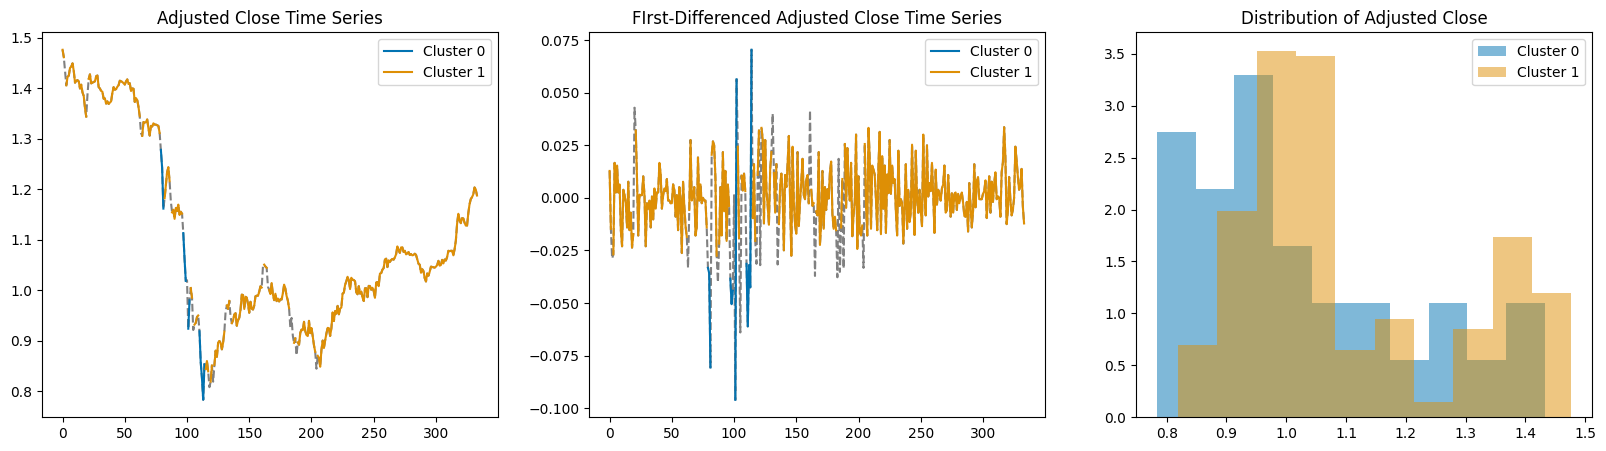

In [9]:
fig = plot_cluster_charts(df, 2, 'gmm_cluster')
plt.show()

In [84]:
gmm_log_likelihood = gmm.score(X)* X.shape[0]
gmm_aic = gmm.aic(X)
gmm_bic = gmm.bic(X)

print(f"""AIC:            {gmm_aic:.4f},
BIC:            {gmm_bic:.4f},
Log-Likelihood: {gmm_log_likelihood:.4f}    
""")


AIC:            -1739.4371,
BIC:            -1720.3814,
Log-Likelihood: 874.7186    



# Mixture Autoregressive Model
In order to address the dependence structure present in time-series data, we will use the Gaussian MAR model. This assumes that the data is generated by a mixture of multiple autoregressive (AR) processes.

At each time step, a latent regime determines which AR process governs the dynamics:
$$F(y_t | \mathcal{F}_{t-1}) = \sum^K_{k=1}\alpha_k\Phi\left(\frac{y_t - \phi_{k,0} - \phi_{k,1}y_{t-1} - ... -  \phi_{k,p_k}y_{t-p_k}}{\sigma_k}\right)$$
where $\alpha_k$ is the mixture weights, $\phi_{k,0}$ is the intercept, $\phi_{k, p_k}$ is the autoregressive coefficients, $\sigma_k$ is the standard deviation of the Gaussian noise in component k.

Meanwhile, the conditional log-likelihood is given by:
$$l = \sum^n_{t=p+1}l_t = \sum^n_{t=p+1}\left[\sum^K_{k=1}Z_{t,k}\left(log(\alpha_k) - log(\sigma_k) - \frac{\epsilon^2_{k,t}}{2\sigma^2_k}\right)\right]$$
where $Z_{t, k}$ is the latent variable indicating the cluster group, and $\epsilon_{k,t} = y_t - \mu_{k,t}$.

Lastly, the expected complete-data log-likelihood can be defined as:
$$Q(\theta, \theta^{old}) = \sum^K_{k=1}\tau_{k,t}log\alpha_k + \sum^K_{k=1}\tau_{k,t}logf_k(y_t|\mathcal{F}_{t-1})$$
where $\tau_{k,t}$ is the conditional mixing probability.

## E-Step
Note that the expected complete-data log-likelihood is controlled by $\tau_{k,t}$, hence we will focus on that.
$$\tau_{k,t} = P(Z_{t,k} = 1 | y_t; \theta)$$
$$\tau_{k,t} = \frac{(\alpha_k/\sigma_k)\phi(\epsilon_{k,t}/\sigma_k)}{\sum^K_{k=1}(\alpha_k/\sigma_k)\phi(\epsilon_{k,t}/\sigma_k)}$$

In [10]:
seed=42
k = 2
phi_orders = [2, 1]

def initial_guess(n_components:int, phi_orders:list[int], seed:int=None) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray]]:
    if n_components != len(phi_orders):
        raise ValueError(f"Number of components must match the number of orders.")
    
    rng = np.random.default_rng(seed)
    alpha = np.ones(n_components)/ n_components #must sum to 1
    sigma = np.ones(n_components)
    phi = [rng.standard_normal(order+1) for order in phi_orders] #Account for order 0 (the intercept)
    
    params = {
        'alpha': alpha,
        'sigma': sigma,
        'phi': phi
    }
    return params

params = initial_guess(k, phi_orders, seed)
print(f"""Initial Guesses:
    a:{params['alpha']},
    s:{params['sigma']},
    phi_1: {params['phi'][0].tolist()},
    phi_2: {params['phi'][1].tolist()} 
"""
)

Initial Guesses:
    a:[0.5 0.5],
    s:[1. 1.],
    phi_1: [0.30471707975443135, -1.0399841062404955, 0.7504511958064572],
    phi_2: [0.9405647163912139, -1.9510351886538364] 



In [11]:
def _reverse_index(x:np.ndarray, from_pt:int, to_pt:int) -> np.ndarray:
    if to_pt == 0:
        return x[from_pt::-1]
    
    return x[from_pt:to_pt-1:-1]

def e_step(y:np.ndarray, alpha:np.ndarray, sigma:np.ndarray, phi:list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
    #Change these to be part of the class
    n_components = 2 
    phi_orders = [len(p)-1 for p in phi] # -1 to account for intercept
    min_timestep = max(phi_orders)
    max_timestep = len(y)
    
    tau = np.zeros(shape=(max_timestep, n_components))
    epsilon = tau.copy()
    for t in range(min_timestep, max_timestep):
        for k in range(n_components):
            p = phi[k]
            start_pt = t - phi_orders[k]
            y_lags = np.array([1] + _reverse_index(y, t-1, start_pt).tolist()) #1 for phi_0, and remaining is in reversed order to get t-1, t-2 ..., t-n
            eps = y[t] - p.T@y_lags
            
            numerator = alpha[k]* (1/sigma[k])* norm.pdf(eps/ sigma[k])
            
            epsilon[t, k] = eps
            tau[t, k] = numerator
        
        tau[t, :] /= np.sum(tau[t, :]) #normalize to sum to 1
    
    return epsilon, tau #(timesteps, n_components)

y = df['first_diff'].to_numpy()
epsilon, tau = e_step(y, **params)
tau_df = pd.DataFrame(tau, columns=['cluster_0', 'cluster_1'])
tau_df.head(5)

,cluster_0,cluster_1
0,0.000000,0.000000
1,0.000000,0.000000
2,0.606788,0.393212
3,0.613597,0.386403
4,0.606659,0.393341


In [12]:
epsilon_df = pd.DataFrame(epsilon, columns=['cluster_0', 'cluster_1'])
epsilon_df.head(5)

,cluster_0,cluster_1
0,0.000000,0.000000
1,0.000000,0.000000
2,-0.358407,-0.998058
3,-0.350481,-1.023597
4,-0.294422,-0.976350


## M-Step
After differentiating $l$ w.r.t all the parameters and setting the RHS to be 0, we get the following:
$$\hat{\alpha}_k = \frac{\sum^n_{t=p+1}\tau_{t,k}}{n-p}$$
$$\hat{\sigma}_k = \left(\frac{\sum^n_{t=p+1}\tau_{t,k}\epsilon^2_{t,k}}{\sum^n_{t=p+1}\tau_{t,k}}\right)^{1/2}$$
where $n$ is the sample size, and $p$ is the autoregressive order of the k-component.

In [13]:
def maximize_alpha(tau_k:np.ndarray, phi_order_k:int) -> float:
    #Change these to be part of the class
    n = 334
    
    filtered_tau = tau_k[phi_order_k+1:]
    numerator = np.sum(filtered_tau)
    denominator = n-phi_order_k
    return numerator/denominator

alpha_vals = {
    'cluster_0': maximize_alpha(tau[:, 0], phi_orders[0]),
    'cluster_1': maximize_alpha(tau[:, 1], phi_orders[1])
}
print(alpha_vals)

{'cluster_0': np.float64(0.5964210345563736), 'cluster_1': np.float64(0.40054482925380236)}


In [14]:
def maximize_sigma(tau_k:np.ndarray, epsilon_k:np.ndarray, phi_order_k:int) -> float:
    filtered_tau = tau_k[phi_order_k+1:]
    filtered_epsilon = epsilon_k[phi_order_k+1:]
    numerator = np.sum(filtered_tau* filtered_epsilon**2)
    denominator = np.sum(tau_k)
    return np.sqrt(numerator/denominator)

sigma_vals = {
    'cluster_0': maximize_sigma(tau[:, 0], epsilon[:, 0], phi_orders[0]),
    'cluster_1': maximize_sigma(tau[:, 1], epsilon[:, 1], phi_orders[1])
}
print(sigma_vals)

{'cluster_0': np.float64(0.3069919463895307), 'cluster_1': np.float64(0.9431312343880383)}


For the $\phi$ values, it will be trickier as we have to satisfy the system of equations:
$$\sum^n_{t=p+1}\tau_{t,k}y_tu(y_t, i) = \sum^{p_k}_{j=0}\hat{\phi}_{k,j}\sum^n_{t=p+1}\tau_{t,k}u(y_t, j)u(y_t, i)$$
$$
u(y_t, i) = 
\begin{cases}
1 & \text{if } i = 0 \\
y_{t-i} & \text{else}
\end{cases}
$$

This can be represented as a weighted least squares matrix problem:
$$
\begin{bmatrix}
\sum \tau y_t u_{t0} \\
\sum \tau y_t u_{t1} \\
\vdots \\
\sum \tau y_t u_{tp_k}
\end{bmatrix}
=
\begin{bmatrix}
\sum \tau u_{t0} u_{t0} & \sum \tau u_{t1} u_{t0} & \cdots & \sum \tau u_{tp_k} u_{t0} \\
\sum \tau u_{t0} u_{t1} & \sum \tau u_{t1} u_{t1} & \cdots & \sum \tau u_{tp_k} u_{t1} \\
\vdots & \vdots & \ddots & \vdots \\
\sum \tau u_{t0} u_{tp_k} & \sum \tau u_{t1} u_{tp_k} & \cdots & \sum \tau u_{tp_k} u_{tp_k}
\end{bmatrix}
\begin{bmatrix}
\hat{\phi}_{k0} \\
\hat{\phi}_{k1} \\
\vdots \\
\hat{\phi}_{kp_k}
\end{bmatrix}
$$
$$b_k = A_k\hat{\phi}_k$$
$$X^T_kW_kY = X^T_kW_kX_k\hat{\phi}_k$$
$$\hat{\phi}_k = (X^T_kW_kX_k)^{-1}X^T_kW_kY$$

The matrices are given as follows:
$$X_k = 
\begin{bmatrix}
1 & y_{t-1} & y_{t-2} & \cdots & y_{t-p_k}\\
1 & y_t & y_{t-1} & \cdots & y_{t+1-p_k}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & y_{n-1} & y_{n-2} & \cdots & y_{n-p_k}
\end{bmatrix}
$$

$$W_k = diag(\tau_{t, k})$$

$$
Y = \begin{bmatrix}y_t & y_{t+1} & \cdots & y_n\end{bmatrix}
$$
where $t = p+1, p+2, ..., n$.

In [15]:
def maximize_phi(y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
    #Change these to be part of the class
    n = 334
    
    W = np.diag(tau_k[phi_order_k:])
    Y = y[phi_order_k:]
    
    y_lags = [y[phi_order_k-p-1: n-p-1] for p in range(phi_order_k)] #(p, n-p)
    X = np.column_stack(
        [np.ones(n-phi_order_k)] + y_lags
    ) #(n-p, p+1)
    
    XT_W = X.T @ W
    A = XT_W @  X
    b = XT_W @ Y

    return np.linalg.solve(A, b)

phi_vals = {
    'cluster_0': maximize_phi(y, tau[:, 0], phi_orders[0]),
    'cluster_1': maximize_phi(y, tau[:, 1], phi_orders[1])
}
print(phi_vals)

{'cluster_0': array([-0.00087435,  0.03512594,  0.01562838]), 'cluster_1': array([-0.00065981,  0.03544043])}


## Convergence Criteria
We will follow the two common criterias:
- **Max Iteration**: When the maximum number of iterations have been processed, the loop will stop and the parameters are fixed. This does not mean convergence, rather it acts as a pre-defiend stopping criteria.
- **Tolerance**: When the difference between the old log-likelihood and the new log-likelihood is within the accepted range, we have found the local optimum parameters.

The log-likelihood is defined as:
$$l(\Theta) = \sum^n_{t=p+1}log\left[\sum^K_{k=1}(\alpha_k/\sigma_k)\exp\left(-\frac{\epsilon^2_{t, k}}{2\sigma^2_k}\right)\right]$$

In [16]:
new_params = {
    'alpha': np.array(list(alpha_vals.values())),
    'sigma': np.array(list(sigma_vals.values())),
    'phi': list(phi_vals.values())
}

new_params

{'alpha': array([0.59642103, 0.40054483]),
 'sigma': array([0.30699195, 0.94313123]),
 'phi': [array([-0.00087435,  0.03512594,  0.01562838]),
  array([-0.00065981,  0.03544043])]}

In [17]:
new_epsilon, new_tau = e_step(y, **new_params)
new_tau_df = pd.DataFrame(new_tau, columns=['cluster_0', 'cluster_1'])
new_tau_df.head(5)

,cluster_0,cluster_1
0,0.000000,0.000000
1,0.000000,0.000000
2,0.820081,0.179919
3,0.820186,0.179814
4,0.820361,0.179639


In [18]:
new_epsilon_df = pd.DataFrame(new_epsilon, columns=['cluster_0', 'cluster_1'])
new_epsilon_df.head(5)

,cluster_0,cluster_1
0,0.000000,0.000000
1,0.000000,0.000000
2,-0.027596,-0.027606
3,-0.024752,-0.025187
4,0.018901,0.018245


In [19]:
def log_likelihood(alpha:np.ndarray[float], sigma:np.ndarray[float], epsilon:np.ndarray) -> float:
    #Change these to be part of the class
    min_timestep = 2
    filtered_epsilon = epsilon[min_timestep:]
    component_densities = (alpha/sigma)* np.exp(-(filtered_epsilon**2)/ (2*sigma**2))
    mixture_density = np.sum(component_densities, axis=1) #sum columns
    return np.sum(np.log(mixture_density))

result = {
    'step_0': log_likelihood(alpha=params['alpha'], sigma=params['sigma'], epsilon=epsilon),
    'step_1': log_likelihood(alpha=new_params['alpha'], sigma=new_params['sigma'], epsilon=new_epsilon)
}
result

{'step_0': np.float64(-75.21212084556805),
 'step_1': np.float64(285.61065995832814)}

## Putting It All Together

In [72]:
class GaussianMAR:
    def __init__(self, data:pd.Series, n_components:int, phi_orders:list[int], tol:float=1e-6, max_iter:int=200, 
                 alpha:np.ndarray[float]=None, sigma:np.ndarray[float]=None, phi:list[np.ndarray[float]]=None, seed:int=None):
        
        if n_components != len(phi_orders):
            raise ValueError(f"Number of components must match the number of phi_orders.")
        
        self.y = data.to_numpy()
        self.n = len(self.y)
        self.n_components = n_components
        self.phi_orders = phi_orders
        
        self.tol = tol
        self.max_iter = max_iter
        
        self.rng = np.random.default_rng(seed)
        self.params = {
            'alpha': alpha,
            'sigma': sigma,
            'phi': phi
        }
        self.initial_guess()
        
        self.min_timestep = max(phi_orders)
        self.train_n = len(self.y) #for AIC/BIC calculation
    
    def initial_guess(self):
        if self.params['alpha'] is None:
            self.params['alpha'] = np.ones(self.n_components)/ self.n_components #must sum to 1
        
        if self.params['sigma'] is None:
            self.params['sigma'] = np.ones(self.n_components)
        
        if self.params['phi'] is None:
            self.params['phi'] = [self.rng.standard_normal(order+1) for order in self.phi_orders] #Account for order 0 (the intercept)
    
    def _reverse_index(self, x:np.ndarray, from_pt:int, to_pt:int) -> np.ndarray:
        if to_pt == 0:
            return x[from_pt::-1]
        
        return x[from_pt:to_pt-1:-1]

    def e_step(self, y:np.ndarray, alpha:np.ndarray, sigma:np.ndarray, phi:list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:        
        tau = np.zeros(shape=(self.n, self.n_components))
        epsilon = tau.copy()
        for t in range(self.min_timestep, self.n):
            for k in range(self.n_components):
                p = phi[k]
                start_pt = t - self.phi_orders[k]
                y_lags = np.array([1] + self._reverse_index(y, t-1, start_pt).tolist()) #1 for phi_0, and remaining is in reversed order to get t-1, t-2 ..., t-n
                eps = y[t] - p.T@y_lags
                
                numerator = (alpha[k]/sigma[k])* norm.pdf(eps/ sigma[k])
                
                epsilon[t, k] = eps
                tau[t, k] = numerator
            
            tau[t, :] /= np.sum(tau[t, :]) #normalize to sum to 1
        
        return epsilon, tau #(timesteps, n_components)
    
    def log_likelihood(self, alpha:np.ndarray[float], sigma:np.ndarray[float], epsilon:np.ndarray) -> float:
        filtered_epsilon = epsilon[self.min_timestep:]
        component_densities = (alpha/sigma)* np.exp(-(filtered_epsilon**2)/ (2*sigma**2))
        mixture_density = np.sum(component_densities, axis=1) #sum columns
        return np.sum(np.log(mixture_density))
    
    def _maximize_alpha(self, tau_k:np.ndarray, phi_order_k:int) -> float:
        filtered_tau = tau_k[phi_order_k+1:]
        numerator = np.sum(filtered_tau)
        denominator = self.n-phi_order_k
        return numerator/denominator
    
    def _maximize_sigma(self, tau_k:np.ndarray, epsilon_k:np.ndarray, phi_order_k:int) -> float:
        filtered_tau = tau_k[phi_order_k+1:]
        filtered_epsilon = epsilon_k[phi_order_k+1:]
        numerator = np.sum(filtered_tau* filtered_epsilon**2)
        denominator = np.sum(tau_k)
        return np.sqrt(numerator/denominator)
    
    def _maximize_phi(self, y:np.ndarray, tau_k:np.ndarray, phi_order_k:int) -> np.ndarray:
        W = np.diag(tau_k[phi_order_k:])
        Y = y[phi_order_k:]
        
        y_lags = [y[phi_order_k-p-1: self.n-p-1] for p in range(phi_order_k)] #(p, n-p)
        X = np.column_stack([np.ones(self.n-phi_order_k)] + y_lags) #(n-p, p+1)
        
        XT_W = X.T @ W
        A = XT_W @  X
        b = XT_W @ Y
    
        return np.linalg.solve(A, b) #More stable than finding the inverse
    
    def m_step(self, tau:np.ndarray, epsilon:np.ndarray) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        alpha, sigma, phi = [], [], []
        for k in range(self.n_components):
            alpha_hat = self._maximize_alpha(tau_k=tau[:, k], phi_order_k=self.phi_orders[k])
            sigma_hat = self._maximize_sigma(tau_k=tau[:, k], epsilon_k=epsilon[:, k], phi_order_k=self.phi_orders[k])
            phi_hat = self._maximize_phi(y=self.y, tau_k=tau[:, k], phi_order_k=self.phi_orders[k])
            
            alpha.append(alpha_hat)
            sigma.append(sigma_hat)
            phi.append(phi_hat)
        
        params = {
            'alpha': np.array(alpha),
            'sigma': np.array(sigma),
            'phi': phi
        }
        return params
    
    def fit(self) -> dict[np.ndarray[float], np.ndarray[float], list[np.ndarray[float]]]:
        self.log_likelihood_vals = []
        curr_log_likelihood = 0
        for i in range(self.max_iter):
            epsilon, self.tau = self.e_step(self.y, **self.params)
            
            old_log_likelihood = curr_log_likelihood
            curr_log_likelihood = self.log_likelihood(self.params['alpha'], self.params['sigma'], epsilon)
            self.log_likelihood_vals.append(curr_log_likelihood)
            if np.abs(curr_log_likelihood - old_log_likelihood) <= self.tol:
                print("Parameters have converged.")
                return self.params
            
            self.params = self.m_step(tau=self.tau, epsilon=epsilon)
        
        print("Max iteration has been reached.")
        return self.params
    
    @property
    def fitted_values(self):
        col_names = [str(f"cluster_{k}") for k in range(self.n_components)]
        df = pd.DataFrame(self.tau, columns=col_names)
        return df
    
    def greedy_assignment(self, tau:np.ndarray) -> pd.Series:
        col_names = [str(f"cluster_{k}") for k in range(self.n_components)]
        df = pd.DataFrame(tau, columns=col_names)
        labels = df.idxmax(axis=1).str[-1].astype(int)
        labels = labels.where(df.nunique(axis=1) > 1, -1)
        return labels
    
    def predict(self, y:float|list|np.ndarray|pd.Series, update_history:bool=False) -> np.ndarray:
        new_y = np.asarray(y).reshape(-1) #1D array
        n = len(new_y)
        tau = np.zeros((n, self.n_components))
        
        for t in range(n):
            for k in range(self.n_components):
                p = self.params['phi'][k]
                phi_order = self.phi_orders[k]
                
                if phi_order == 0:
                    y_lags = np.array([1])
                elif phi_order > 0:
                    y_lags = self.y[-phi_order:]
                    y_lags = np.array([1] + y_lags[::-1].tolist())
                eps = new_y[t] - p.T @ y_lags
                
                alpha = self.params['alpha'][k]
                sigma = self.params['sigma'][k]
                numerator = (alpha/sigma)* norm.pdf(eps/sigma)
                tau[t, k] = numerator
            
            tau[t, :] /= np.sum(tau[t, :])
        
        if update_history:
            self.update_history(y)
        
        return tau
    
    def update_history(self, y:float|list|np.ndarray|pd.Series):
        new_y = np.asarray(y).reshape(-1)
        self.y = np.append(self.y, new_y)
        self.n = len(self.y)
    
    @property
    def aic(self):
        val = -2*self.log_likelihood_vals[-1] +\
            2*(3*self.n_components - 1 + np.sum(self.phi_orders))
        return val
    
    @property
    def bic(self):
        val = -2*self.log_likelihood_vals[-1] +\
            np.log(self.train_n - self.min_timestep) *\
            (3*self.n_components - 1 + np.sum(self.phi_orders))
        return val

In the paper, their parameter estimates for ($\alpha_1, \alpha_2, \alpha_3, \sigma_1, \sigma_2, \sigma_3, \phi_{11}, \phi_{21}$) are $(0.5439, 0.4176, 0.0385, 4.8227, 6.0082, 18.1716, -0.3208, 0.6711)$.

Meanwhile, our estimates are $(0.5823, 0.3814, 0.0333, 0.0120, 0.0151, 0.0483, -0.3537, 0.6388)$. Additionally, the parameter estimates for the intercepts $(\phi_{10}, \phi_{20}, \phi_{30})$ are $(0.0026, -0.0054, -0.0133)$ 

Our estimates are quite close to the paper's, so we can be confident that the algorithm works similarly. The differences can be attributed to the functions used from libraries and the difference in date range.

Notably, there is a big difference in the $\sigma$ values. This is due to the difference in price magnitude as we are using the adjusted close from Yahoo Finance. Their price range from 300 to 500, while our range from 0.8 to 1.5.

In [73]:
mar = GaussianMAR(df['first_diff'], n_components=3, phi_orders=[1, 1, 0], seed=seed)
mar.fit()

Parameters have converged.


{'alpha': array([0.58231266, 0.38135478, 0.03327979]),
 'sigma': array([0.01203265, 0.01506194, 0.04825666]),
 'phi': [array([ 0.00255717, -0.3536912 ]),
  array([-0.00544559,  0.63883118]),
  array([-0.01328538])]}

We also note that the AIC, BIC and log-likelihood are all significantly better than the GMM, indicating a better overall fit.

In [82]:
print(f"""AIC:            {mar.aic:.4f},
BIC:            {mar.bic:.4f},
Log-Likelihood: {mar.log_likelihood_vals[-1]:.4f}    
""")

AIC:            -2371.6033,
BIC:            -2333.5219,
Log-Likelihood: 1195.8017    



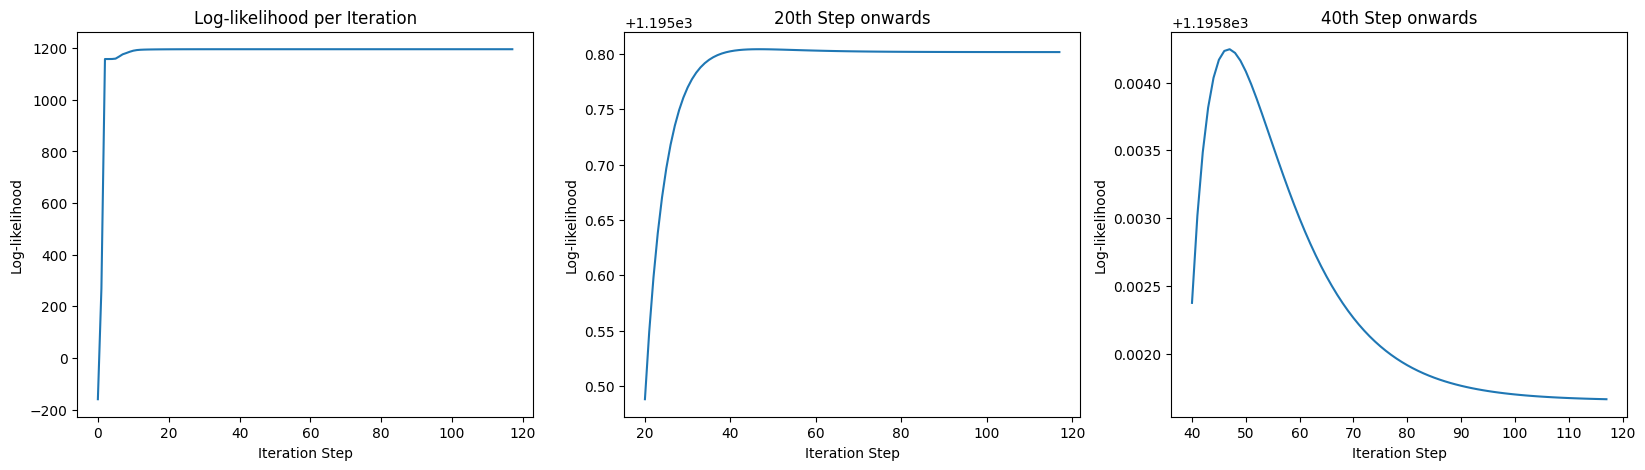

In [66]:
fig, axes= plt.subplots(ncols=3, figsize=(20,5))
log_likelihood_vals = pd.DataFrame(mar.log_likelihood_vals, columns=['log_likelihood'])

axes[0].plot(log_likelihood_vals)
axes[0].set_title("Log-likelihood per Iteration")
axes[0].set_ylabel("Log-likelihood")
axes[0].set_xlabel("Iteration Step")

axes[1].plot(log_likelihood_vals[20:])
axes[1].set_title("20th Step onwards")
axes[1].set_ylabel("Log-likelihood")
axes[1].set_xlabel("Iteration Step")

axes[2].plot(log_likelihood_vals[40:])
axes[2].set_title("40th Step onwards")
axes[2].set_ylabel("Log-likelihood")
axes[2].set_xlabel("Iteration Step")

plt.show()

In [67]:
mar.fitted_values.head(5)

,cluster_0,cluster_1,cluster_2
0,0.000000,0.000000,0.000000
1,0.669373,0.313919,0.016709
2,0.027233,0.935619,0.037149
3,0.008364,0.965833,0.025803
4,0.969443,0.018304,0.012253


In [68]:
df['mar_cluster'] = mar.greedy_assignment(mar.tau)
df.head(5)

,date,adj_close,log_return,first_diff,gmm_cluster,mar_cluster
0,1962-01-03,1.476464,0.008703,0.012793,1,-1
1,1962-01-04,1.461751,-0.010015,-0.014713,1,0
2,1962-01-05,1.432963,-0.019890,-0.028788,0,1
3,1962-01-08,1.406096,-0.018927,-0.026867,1,1
4,1962-01-09,1.422729,0.011760,0.016633,1,0


Based on the charts, we see a notable difference in the effectiveness of using MAR as compared to GMM.

The clusters correspond to the following market regimes:
- **Cluster 0**: Normal market with a stable, low-volatility trending periods where the price moves gradually without large jumps.
- **Cluster 1**: Excited market with directional drift or momentum, where the price moves sharply.
- **Cluster 2**: Marks transitions or disruptions in the market.

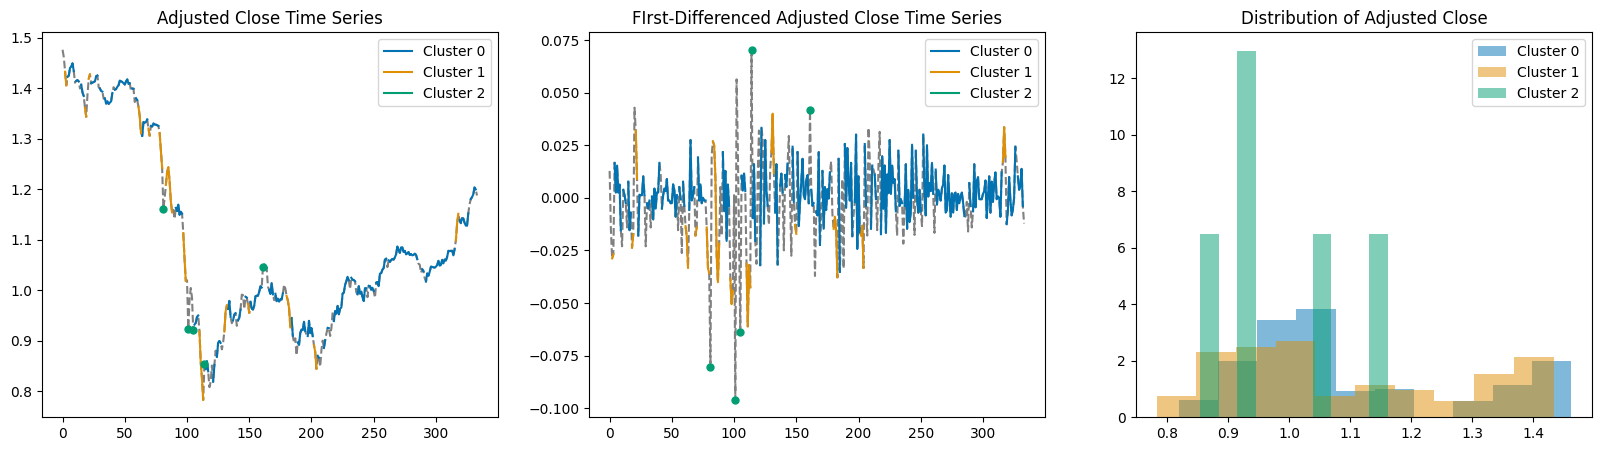

In [69]:
fig = plot_cluster_charts(df, 3, 'mar_cluster')
for ax in fig.axes[:-1]:
    for line in ax.lines:
        if line.get_label() == 'Cluster 2':
            line.set_linestyle('None')
            line.set_marker('o')
            line.set_markersize(5)

plt.show()

# Example Usage

Though the researchers converted the three-component MAR model for the differenced series to the original series, we will not be following that methodology.

In our case, the purpose was to classify the market regime given a new set of returns. Meanwhile, their purpose was to forecast using the predictive distributions.

If you are interested in understanding how the conversion works, I have illustrated the steps in the last page of the workings file ("mar_workings.pdf").

In [71]:
rng = np.random.default_rng(seed=seed)
new_y = rng.choice(y, size=5)
new_tau = mar.predict(new_y, update_history=False)
new_df = pd.DataFrame({
    'first_diff': new_y,
    'cluster_0': new_tau[:, 0],
    'cluster_1': new_tau[:, 1],
    'cluster_2': new_tau[:, 2],
    'mar_cluster': mar.greedy_assignment(new_tau)
})
new_df.head(5)

,first_diff,cluster_0,cluster_1,cluster_2,mar_cluster
0,-0.023033,0.094633,0.876443,0.028924,1
1,0.003201,0.759554,0.229752,0.010693,0
2,-0.017284,0.204789,0.773437,0.021774,1
3,-0.027516,0.046417,0.916093,0.037490,1
4,0.029435,0.899978,0.049647,0.050375,0
